<a href="https://colab.research.google.com/github/augustinechang1/LSTM_RNN_Prediction/blob/master/LSTM_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install alpha_vantage

  Stored in directory: /root/.cache/pip/wheels/21/9c/02/b7cfae63f7119f4089f229ba1a09ce90fabbaf96199c2890be
Successfully built alpha-vantage


feedforward nets
Input examples fed into network, transformed into an output

Recurrent Networks
Remembers previous inputs
Two sources of input:
    1. Present
    2. Recent past
Feedback loop connected to past decisions, ingests own output after moment as input
recurrent networks have memory, storing information in sequence itself
Finds correlation b/w events, known as "long-term dependencies"
RNN's share weights over time


https://www.youtube.com/watch?v=zwqwlR48ztQ


In [0]:
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [0]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [29]:
ts = TimeSeries(key='X5AYBIDIH2EVGNW9', output_format='pandas')
stock, meta_data = ts.get_daily(symbol='DJIA', outputsize='full')
stock = stock['4. close']
df = pd.DataFrame({'Date':stock.index, 'Close':stock.values})
df.head()

,Date,Close
0,2000-01-03,11357.5098
1,2000-01-04,10997.9297
2,2000-01-05,11122.6504
3,2000-01-06,11253.2598
4,2000-01-07,11522.5596


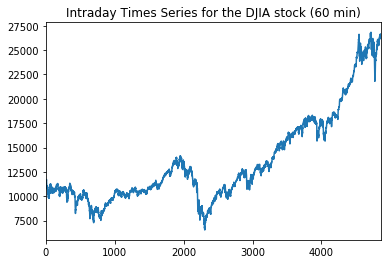

In [30]:
df['Close'].plot()
plt.title('Intraday Times Series for the DJIA stock (60 min)')
plt.show()

In [0]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [0]:
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [0]:
#creating train and test sets (80% train, 20% valid)
dataset = new_data.values
train = dataset[0:3883,:]
valid = dataset[3883:,:]

In [34]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
# Create a data structure with 60 timesteps and 1 output
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshaping (batch_size, timesteps, input_dim)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [43]:
x_train.shape[0]

3823

In [37]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1)) #1 output (prediction of next day)

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 183s - loss: 3.6719e-04
Epoch 2/10
 - 179s - loss: 1.2142e-04
Epoch 3/10
 - 180s - loss: 9.3034e-05
Epoch 4/10
 - 180s - loss: 8.0227e-05
Epoch 5/10
 - 179s - loss: 7.5027e-05
Epoch 6/10
 - 180s - loss: 7.2035e-05
Epoch 7/10
 - 179s - loss: 7.1966e-05
Epoch 8/10
 - 179s - loss: 6.3206e-05
Epoch 9/10
 - 178s - loss: 6.6350e-05
Epoch 10/10
 - 180s - loss: 6.5107e-05


In [0]:

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

In [39]:
X_test.shape

(976, 60)

In [0]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [41]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

605.4730610107054

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


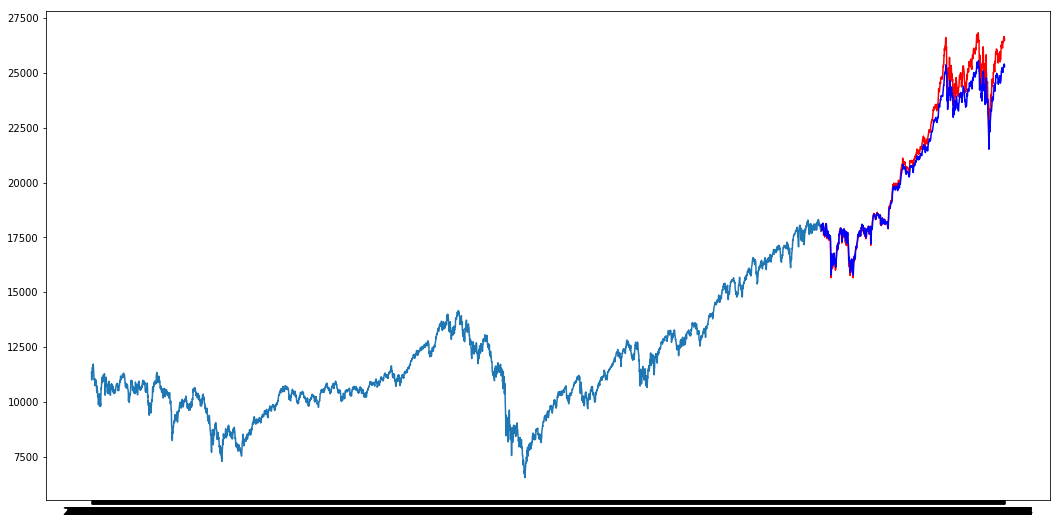

In [42]:
#for plotting
train = new_data[:3883]
valid = new_data[3883:]
valid['Predictions'] = closing_price
plt.figure(figsize=(18,9))
plt.plot(train['Close'])
plt.plot(valid['Close'], color = 'red', label = 'Real Stock Price')
plt.plot(valid['Predictions'], color = 'blue', label = 'Predicted Stock Price')
